In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import psutil
plt.style.use('ggplot')

import torch
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer, TextStreamer, AutoTokenizer, AutoModelForSequenceClassification

import datasets
# from unsloth.chat_templates import get_chat_template
# from unsloth import FastLanguageModel
# from datasets import Dataset
# from unsloth import is_bfloat16_supported


# Warnings
import warnings
warnings.filterwarnings("ignore")



%matplotlib inline


In [2]:
from tokenize_simple import get_genqa_data, get_tokenized_data, flatten_genqa_conversations, my_tokenize

import logging
log = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.INFO,  # Set the minimum log level
    format="%(asctime)s - %(levelname)s - %(message)s",  # Include time, level, and message
    datefmt="%Y-%m-%d %H:%M:%S"  # Specify the date and time format
)


batch_size = 500

try:
    threads = min(psutil.cpu_count(logical=False), len(psutil.Process().cpu_affinity()))
except:
    threads = os.cpu_count()


# Load the model and tokenizer
log.info("Loading model and tokenizer...")
model_name = "meta-llama/Llama-3.2-1B"

raw_data_name = "genqa"
ext = "math"
ds_path = f"/fs/cml-projects/llm-pretraining/datasets/raw/{raw_data_name}/{ext}"

pre_tok_name = "empty"
tokenizer_path_old = f"/cmlscratch/astein0/LLM-pretraining/LLM-pretraining-tokenization/tokenizers/Llama-3.2-tokenizer-genqa-{ext}-{pre_tok_name}-start"
tokenizer_file_old = "new_mergeable_ranks_2000.model"
vocab_file_path = f"{tokenizer_path_old}/{tokenizer_file_old}"

# DATASET
# dataset_path = "/fs/cml-projects/llm-pretraining/datasets/processed/ultrachat/train"
dataset_path = f"/fs/cml-projects/llm-pretraining/datasets/raw/{raw_data_name}/{ext}"

log.info("Downloading and processing raw dataset")
# tokenizer, data, tokenized_dataset = get_tokenized_data(vocab_file_path, ds_path, pre_tok_name=pre_tok_name)

# get original_tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# data = get_genqa_data(dataset_path)
# tokenized_dataset = my_tokenize(data.select_columns("text"), tokenizer)
# tokenized_dataset = tokenized_dataset.map(lambda batch: {"num_tokens": [len(ids) for ids in batch["input_ids"]]}, batched=True, batch_size=batch_size, num_proc=threads)




2025-02-23 15:03:14 - INFO - Loading model and tokenizer...
2025-02-23 15:03:14 - INFO - Downloading and processing raw dataset


In [3]:
import tokenize_simple
from tokenize_simple import get_tokenized_data, flatten_genqa_conversations, my_tokenize

import importlib
importlib.reload(tokenize_simple)

model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# tokenizer.pad_token = tokenizer.eos_token

# # data = tokenize_simple.get_genqa_data(dataset_path, tokenizer=tokenizer, track_role=True)
# data = tokenize_simple.get_genqa_data(dataset_path, track_role=True)
# tokenized_dataset = my_tokenize(data.select_columns("text"), tokenizer)
# tokenized_dataset = tokenized_dataset.map(lambda batch: {"num_tokens": [len(ids) for ids in batch["input_ids"]]}, batched=True, batch_size=batch_size, num_proc=threads)



In [4]:
tokenizer

PreTrainedTokenizerFast(name_or_path='meta-llama/Llama-3.2-1B', vocab_size=128000, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|end_of_text|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	128000: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|finetune_right_pad_id|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128005: AddedToken("<|reserved_special_token_2|>", rstri

In [37]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

model_name = "meta-llama/Llama-3.2-1B"
batch_size = 4

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

dataset_path = "/cmlscratch/astein0/efficient_tokenization_for_inference/datasets/test"
tokenized_dataset = datasets.load_from_disk(dataset_path)

# Split the dataset into train (90%) and validation (10%)
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.1)
# tokenized_dataset[0]

tokenized_dataset["train"] = tokenized_dataset["train"].remove_columns(["text", "num_tokens"])

data_collator = DataCollatorWithPadding(tokenizer, max_length=2048, padding=True)
ds = tokenized_dataset["train"].select(range(16))
print(ds[0])
train_loader = DataLoader(
    tokenized_dataset["train"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=4,
    pin_memory=True
)

{'input_ids': [128000, 27, 91, 882, 91, 29, 7531, 279, 24524, 315, 279, 11277, 430, 5727, 279, 1486, 320, 16, 11, 220, 17, 11, 220, 18, 8, 323, 430, 374, 77933, 311, 279, 1584, 12579, 1555, 279, 3585, 320, 15, 11, 220, 15, 11, 220, 15, 8, 323, 320, 17, 11, 220, 19, 11, 220, 21, 570, 27, 91, 78191, 91, 29, 5629, 11, 1505, 279, 5216, 4724, 315, 279, 1584, 12579, 1555, 279, 3585, 320, 15, 11, 220, 15, 11, 220, 15, 8, 323, 320, 17, 11, 220, 19, 11, 220, 21, 7887, 14196, 4077, 85, 284, 366, 17, 12, 15, 11, 220, 19, 12, 15, 11, 220, 21, 12, 15, 29, 284, 366, 17, 11, 220, 19, 11, 220, 21, 397, 14196, 19884, 12834, 279, 11277, 374, 77933, 311, 420, 1584, 11, 1202, 4725, 4724, 374, 15638, 311, 348, 13, 14636, 11, 279, 4725, 4724, 315, 279, 11277, 374, 1473, 14196, 4077, 77, 284, 366, 17, 11, 220, 19, 11, 220, 21, 397, 14196, 19884, 7184, 11, 1005, 279, 1486, 53183, 1376, 315, 279, 24524, 315, 264, 11277, 311, 1505, 279, 24524, 315, 279, 11277, 1473, 14196, 4077, 17, 2120, 482, 220, 16, 8, 489, 

In [38]:
sample_batch = [ds[i] for i in range(16)]

# Convert lists to PyTorch tensors before collation
for example in sample_batch:
    example["input_ids"] = torch.tensor(example["input_ids"], dtype=torch.long)
    example["attention_mask"] = torch.tensor(example["attention_mask"], dtype=torch.long)
    example["labels"] = torch.tensor(example["labels"], dtype=torch.long)

collated_batch = data_collator(sample_batch)
print(collated_batch)

# sample_batch = [tokenized_dataset["train"][i] for i in range(4)]  # Pick a few examples
# collated_batch = data_collator(sample_batch)
# print(collated_batch)
# print(next(iter(train_loader)))

ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`labels` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

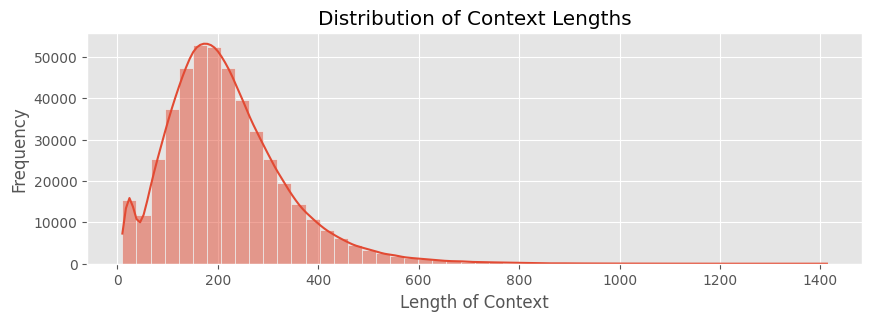

In [2]:
# data['Context_length'] = tokenized_dataset.select_columns('num_tokens').apply(len)
# dataset_path = "/cmlscratch/astein0/efficient_tokenization_for_inference/datasets/test"
dataset_path = "/cmlscratch/astein0/efficient_tokenization_for_inference/datasets/new_tokenized"
# args.dataset

ds = datasets.load_from_disk(dataset_path)

# Split the dataset into train (90%) and validation (10%)
ds = ds.train_test_split(test_size=0.1)

plt.figure(figsize=(10, 3))
sns.histplot(ds["train"]['num_tokens'], bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()

Map (num_proc=16): 100%|█████████▉| 515070/515509 [00:10<00:00, 19018.02 examples/s]Traceback (most recent call last):
  File "/nfshomes/astein0/.pyenv/versions/3.10.4/envs/eff-tok/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/nfshomes/astein0/.pyenv/versions/3.10.4/envs/eff-tok/lib/python3.10/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/nfshomes/astein0/.pyenv/versions/3.10.4/envs/eff-tok/lib/python3.10/site-packages/multiprocess/managers.py", line 599, in _run_server
    server.serve_forever()
  File "/nfshomes/astein0/.pyenv/versions/3.10.4/envs/eff-tok/lib/python3.10/site-packages/multiprocess/managers.py", line 184, in serve_forever
    sys.exit(0)
SystemExit: 0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/nfshomes/astein0/.pyenv/versions/3.10.4/envs/eff-tok/lib/python3.10/site-packages/mult

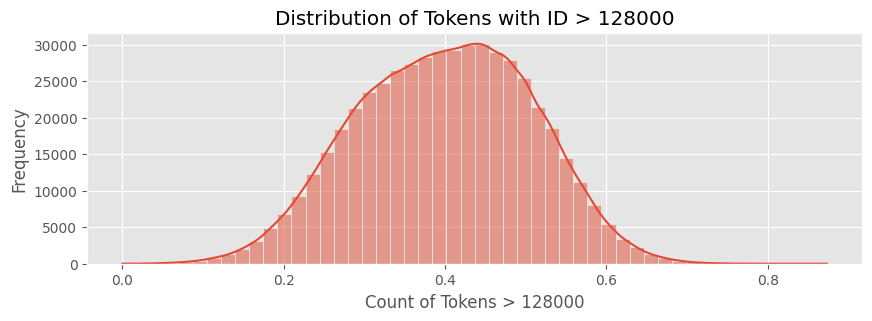

Average tokens > 128000 per example: 86.5045964279964
Max tokens > 128000 in any example: 660
Total tokens > 128000: 44593898


In [8]:
## CHECKING NEW TOKENS
import datasets
batch_size = 1000
threads = 16
dataset_path = "/cmlscratch/astein0/efficient_tokenization_for_inference/datasets/new_tokenized"
# args.dataset

ds = datasets.load_from_disk(dataset_path)

def count_large_tokens(batch):
    # Count tokens > 1000 in each example's input_ids
    counts = [sum(1 for token_id in ids if token_id > 128000) for ids in batch['input_ids']]
    totals = [len(ids) for ids in batch['input_ids']]
    percents = [count/total for count, total in zip(counts, totals)]
    return {'large_token_count': counts, 'total_tokens': totals, 'percent_large_tokens': percents}

if "large_token_count" not in ds.column_names:
    # Apply the counting function to the dataset with batching
    dataset_with_counts = ds.map(
        count_large_tokens, 
        batched=True, 
        batch_size=batch_size, 
        num_proc=threads
    )

# You can then analyze the distribution
plt.figure(figsize=(10, 3))
# sns.histplot(dataset_with_counts['large_token_count'], bins=50, kde=True)
sns.histplot(dataset_with_counts['percent_large_tokens'], bins=50, kde=True)
plt.title('Distribution of Tokens with ID > 128000')
plt.xlabel('Count of Tokens > 128000')
plt.ylabel('Frequency')
plt.show()

# Print some statistics
print("Average tokens > 128000 per example:", np.mean(dataset_with_counts['large_token_count']))
print("Max tokens > 128000 in any example:", np.max(dataset_with_counts['large_token_count']))
print("Total tokens > 128000:", sum(dataset_with_counts['large_token_count']))


In [5]:
batch_size = 2
gradient_accumulation_steps = 8
processes = 8
print(len(ds["train"]) / batch_size / gradient_accumulation_steps / processes)


3624.671875


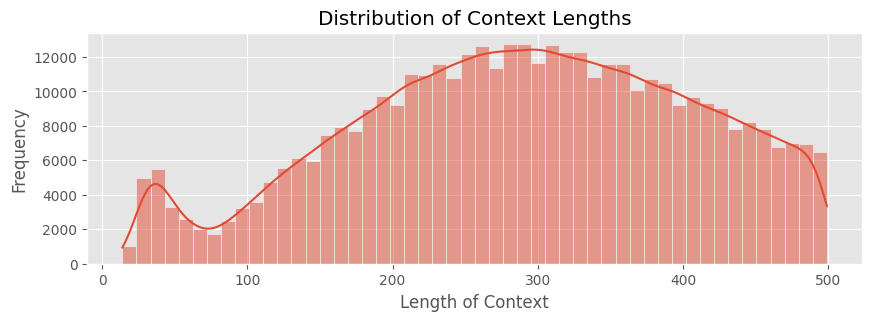

In [35]:
# filtered_data = tokenized_dataset[tokenized_dataset['num_tokens'] <= 500]
filtered_data = tokenized_dataset.filter(
    lambda batch: [num_tokens < 2000 for num_tokens in batch["num_tokens"]],
    batched=True, 
    batch_size=batch_size, 
    num_proc=threads
)

# ln_Context = filtered_data['num_tokens'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(filtered_data['num_tokens'], bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()

In [7]:
max_seq_length = 2048
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-1B-bnb-4bit",
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    dtype=None,
)

model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    lora_alpha=16,
    lora_dropout=0,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],
    use_rslora=True,
    use_gradient_checkpointing="unsloth",
    random_state = 32,
    loftq_config = None,
)
print(model.print_trainable_parameters())


==((====))==  Unsloth 2025.1.8: Fast Llama patching. Transformers: 4.47.1.
   \\   /|    GPU: NVIDIA RTX A6000. Max memory: 47.529 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9039
None


In [ ]:
trainer.train()

EXTEND VOCAB

In [1]:
import torch
from liger_kernel.transformers import AutoLigerKernelForCausalLM
from tokenize_simple import get_tokenizer, AutoTokenizer

model_name = "meta-llama/Llama-3.2-1B"
# tokenizer_path = "/cmlscratch/astein0/LLM-pretraining/LLM-pretraining-tokenization/tokenizers/Llama-3.2-tokenizer-genqa-math-empty-start/new_mergeable_ranks_2000.model"
tokenizer_path = "/cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/Llama-3.2-tokenizer-genqa-math-empty-start-1000"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

model = AutoLigerKernelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    attn_implementation="sdpa",
    use_cache=False,  # Disable KV cache during training
    # device_map="auto"  # Let accelerate handle device mapping
)

/nfshomes/astein0/.pyenv/versions/3.10.4/envs/eff-tok/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tokenizer_object None


In [4]:
new_tokenizer_path = "/cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/Llama-3.2-tokenizer-genqa-math-empty-start-1000"
print("Loading tokenizer...")
extended_tokenizer = AutoTokenizer.from_pretrained(new_tokenizer_path)
texts = ['Translate the following text into the same text but with fewer tokens: text1: <|user|> Find the area of a trapezoid with bases of 8 cm and 12 cm and an altitude of 6 cm. Both bases are extended by 3 cm to form a new trapezoid. Find the area of the new trapezoid. Express your answer in simplified form.<|assistant|> The area of the original trapezoid is:\n\n```\nArea = (8 cm + 12 cm) * 6 cm / 2 = 60 cm²\n```\n\nThe ratio of the bases of the new trapezoid to the old trapezoid is:\n\n```\nRatio = (8 cm + 3 cm + 12 cm + 3 cm) / (8 cm + 12 cm) = 1\n```\n\nSince the bases are in the same ratio, the areas of the trapezoids will also be in the same ratio, so the area of the new trapezoid is:\n\n```\nNew Area = 60 cm² * 1 = 60 cm²\n```<|user|> If the original trapezoid is partitioned into two congruent right triangles by the altitude, what is the area of each triangle?<|assistant|> The area of each triangle is:\n\n```\nTriangle Area = (8 cm + 12 cm) * 6 cm / 2 / 2 = 30 cm²\n```text2: <|user|> Find the area of a trapezoid with bases of 8 cm and 12 cm and an altitude of 6 cm. Both bases are extended by 3 cm to form a new trapezoid. Find the area of the new trapezoid. Express your answer in simplified form.<|assistant|> The area of the original trapezoid is:\n\n```\nArea = (8 cm + 12 cm) * 6 cm / 2 = 60 cm²\n```\n\nThe ratio of the bases of the new trapezoid to the old trapezoid is:\n\n```\nRatio = (8 cm + 3 cm + 12 cm + 3 cm) / (8 cm + 12 cm) = 1\n```\n\nSince the bases are in the same ratio, the areas of the trapezoids will also be in the same ratio, so the area of the new trapezoid is:\n\n```\nNew Area = 60 cm² * 1 = 60 cm²\n```<|user|> If the original trapezoid is partitioned into two congruent right triangles by the altitude, what is the area of each triangle?<|assistant|> The area of each triangle is:\n\n```\nTriangle Area = (8 cm + 12 cm) * 6 cm / 2 / 2 = 30 cm²\n```', "Translate the following text into the same text but with fewer tokens: text1: <|user|> Consider the differential equation:\n\n```y'' + y' - 2y = e^-x```\n\nSolve this equation using the method of undetermined coefficients.<|assistant|> Step 1: Find the Solution to the Homogeneous Equation \n\nThe homogeneous equation is:\n\n```y'' + y' - 2y = 0```\n\nIts characteristic equation is:\n\n```r^2 + r - 2 = 0```\n\nSolving for the roots, we get:\n\n```r = 1 ± √3i```\n\nTherefore, the solution to the homogeneous equation is:\n\n```y_h(x) = e^x (c_1 cos √3 x + c_2 sin √3 x)```\n\n Step 2: Find a Particular Solution to the Non-Homogeneous Equation \n\nSince the non-homogeneous term is e^-x, we guess a particular solution of the form:\n\n```y_p(x) = Ae^-x```\n\nDifferentiating twice, we get:\n\n```y_p'(x) = -Ae^-x```\n\n```y_p''(x) = Ae^-x```\n\nSubstituting these into the non-homogeneous equation, we get:\n\n```Ae^-x - Ae^-x - 2Ae^-x = e^-x```\n\nSolving for A, we get:\n\n```A = 1/2```\n\nTherefore, the particular solution is:\n\n```y_p(x) = (1/2)e^-x```\n\n Step 3: Combine the Homogeneous and Particular Solutions \n\nThe general solution to the non-homogeneous equation is:\n\n```y(x) = y_h(x) + y_p(x)```\n\n```y(x) = e^x (c_1 cos √3 x + c_2 sin √3 x) + (1/2)e^-x```<|user|> Find the general solution to the following differential equation:\n\n```y''' - 3y'' + 2y' - y = 0```<|assistant|> Step 1: Find the Solution to the Homogeneous Equation \n\nThe homogeneous equation is:\n\n```y''' - 3y'' + 2y' - y = 0```\n\nIts characteristic equation is:\n\n```r^3 - 3r^2 + 2r - 1 = 0```\n\nFactoring, we get:\n\n```(r - 1)^2 (r - 1) = 0```\n\nTherefore, the roots are:\n\n```r = 1, 1, 1```\n\nTherefore, the solution to the homogeneous equation is:\n\n```y_h(x) = c_1 e^x + c_2 x e^x + c_3 x^2 e^x```\n\n Step 2: Find a Particular Solution to the Non-Homogeneous Equation \n\nSince the non-homogeneous term is 0, the particular solution is:\n\n```y_p(x) = 0```\n\n Step 3: Combine the Homogeneous and Particular Solutions \n\nThe general solution to the non-homogeneous equation is:\n\n```y(x) = y_h(x) + y_p(x)```\n\n```y(x) = c_1 e^x + c_2 x e^x + c_3 x^2 e^x```text2: <|user|> Consider the differential equation:\n\n```y'' + y' - 2y = e^-x```\n\nSolve this equation using the method of undetermined coefficients.<|assistant|> Step 1: Find the Solution to the Homogeneous Equation \n\nThe homogeneous equation is:\n\n```y'' + y' - 2y = 0```\n\nIts characteristic equation is:\n\n```r^2 + r - 2 = 0```\n\nSolving for the roots, we get:\n\n```r = 1 ± √3i```\n\nTherefore, the solution to the homogeneous equation is:\n\n```y_h(x) = e^x (c_1 cos √3 x + c_2 sin √3 x)```\n\n Step 2: Find a Particular Solution to the Non-Homogeneous Equation \n\nSince the non-homogeneous term is e^-x, we guess a particular solution of the form:\n\n```y_p(x) = Ae^-x```\n\nDifferentiating twice, we get:\n\n```y_p'(x) = -Ae^-x```\n\n```y_p''(x) = Ae^-x```\n\nSubstituting these into the non-homogeneous equation, we get:\n\n```Ae^-x - Ae^-x - 2Ae^-x = e^-x```\n\nSolving for A, we get:\n\n```A = 1/2```\n\nTherefore, the particular solution is:\n\n```y_p(x) = (1/2)e^-x```\n\n Step 3: Combine the Homogeneous and Particular Solutions \n\nThe general solution to the non-homogeneous equation is:\n\n```y(x) = y_h(x) + y_p(x)```\n\n```y(x) = e^x (c_1 cos √3 x + c_2 sin √3 x) + (1/2)e^-x```<|user|> Find the general solution to the following differential equation:\n\n```y''' - 3y'' + 2y' - y = 0```<|assistant|> Step 1: Find the Solution to the Homogeneous Equation \n\nThe homogeneous equation is:\n\n```y''' - 3y'' + 2y' - y = 0```\n\nIts characteristic equation is:\n\n```r^3 - 3r^2 + 2r - 1 = 0```\n\nFactoring, we get:\n\n```(r - 1)^2 (r - 1) = 0```\n\nTherefore, the roots are:\n\n```r = 1, 1, 1```\n\nTherefore, the solution to the homogeneous equation is:\n\n```y_h(x) = c_1 e^x + c_2 x e^x + c_3 x^2 e^x```\n\n Step 2: Find a Particular Solution to the Non-Homogeneous Equation \n\nSince the non-homogeneous term is 0, the particular solution is:\n\n```y_p(x) = 0```\n\n Step 3: Combine the Homogeneous and Particular Solutions \n\nThe general solution to the non-homogeneous equation is:\n\n```y(x) = y_h(x) + y_p(x)```\n\n```y(x) = c_1 e^x + c_2 x e^x + c_3 x^2 e^x```"]

extended_tokenizer(texts, add_special_tokens=False)

Loading tokenizer...
tokenizer_object None


{'input_ids': [[28573, 128440, 1495, 128387, 1890, 1495, 719, 449, 17162, 11460, 25, 1495, 16, 25, 83739, 882, 91, 29, 128397, 129063, 490, 2070, 89, 590, 449, 23963, 315, 128457, 10166, 323, 128641, 10166, 323, 459, 36958, 315, 128381, 10166, 13, 11995, 23963, 527, 11838, 555, 128266, 10166, 311, 1376, 264, 502, 490, 2070, 89, 590, 128726, 128453, 502, 490, 2070, 89, 590, 13, 17855, 701, 4320, 304, 44899, 1376, 16134, 91, 78191, 91, 29, 578, 128453, 4113, 490, 2070, 89, 590, 128365, 8900, 128284, 23, 10166, 128310, 717, 10166, 128332, 128381, 10166, 129199, 128256, 1399, 10166, 30556, 128951, 11595, 128261, 23963, 128261, 502, 490, 2070, 89, 590, 128285, 2362, 490, 2070, 89, 590, 128365, 23617, 128284, 23, 10166, 128349, 10166, 128310, 717, 10166, 128349, 10166, 128832, 23, 10166, 128310, 717, 10166, 128399, 128272, 128499, 23963, 527, 128321, 1890, 11595, 128268, 5789, 128261, 490, 2070, 89, 17390, 690, 1101, 387, 128321, 1890, 11595, 129016, 128453, 502, 490, 2070, 89, 590, 128365, 

In [41]:
import extend_embeddings

import importlib
importlib.reload(extend_embeddings)
import json


# tokenizer_json = json.loads(tokenizer._tokenizer.to_str())

# merge_list = tokenizer_json["model"]["merges"]
# print(merge_list[0])
# print(len(merge_list))
embedding_init_strategy = "merge"
num_new_tokens = len(tokenizer) - model.config.vocab_size

print(tokenizer._tokenizer.id_to_token(128260))

tokenizer.convert_ids_to_tokens(128000)

# Extend model embeddings
print(f"Extending model embeddings with strategy: {embedding_init_strategy}")
model = extend_embeddings.extend_model_embeddings(
    model, 
    num_new_tokens, 
    init_strategy=embedding_init_strategy,
    tokenizer=tokenizer
)

```Ċ
Extending model embeddings with strategy: merged
The OrderedVocab you are attempting to save contains holes for indices [128000, 128001, 128002, 128003, 128004, 128005, 128006, 128007, 128008, 128009, 128010, 128011, 128012, 128013, 128014, 128015, 128016, 128017, 128018, 128019, 128020, 128021, 128022, 128023, 128024, 128025, 128026, 128027, 128028, 128029, 128030, 128031, 128032, 128033, 128034, 128035, 128036, 128037, 128038, 128039, 128040, 128041, 128042, 128043, 128044, 128045, 128046, 128047, 128048, 128049, 128050, 128051, 128052, 128053, 128054, 128055, 128056, 128057, 128058, 128059, 128060, 128061, 128062, 128063, 128064, 128065, 128066, 128067, 128068, 128069, 128070, 128071, 128072, 128073, 128074, 128075, 128076, 128077, 128078, 128079, 128080, 128081, 128082, 128083, 128084, 128085, 128086, 128087, 128088, 128089, 128090, 128091, 128092, 128093, 128094, 128095, 128096, 128097, 128098, 128099, 128100, 128101, 128102, 128103, 128104, 128105, 128106, 128107, 128108, 12

In [12]:
# FIXING UNTRAINED TOKENS

import extend_embeddings

import importlib
importlib.reload(extend_embeddings)

pre_embeddings = model.get_input_embeddings().weight.data.clone()
pre_lm_head = model.get_output_embeddings().weight.data.clone()
mean_embedding, mean_lm_head = extend_embeddings.fix_untrained_tokens(model)
post_embeddings = model.get_input_embeddings().weight.data.clone()
post_lm_head = model.get_output_embeddings().weight.data.clone()

print((pre_embeddings==post_embeddings).all())
print((pre_lm_head==post_lm_head).all())

num_new_tokens = 1000

old_length = model.config.vocab_size
print(f"Old length: {old_length}")
# tokenizer.add_tokens(new_tokens)
new_length = old_length + num_new_tokens
print(f"New length: {new_length}")

embedding_matrix = model.get_input_embeddings ().weight.data
lm_head_matrix   = model.get_output_embeddings().weight.data
print(embedding_matrix)
print(lm_head_matrix)

new_embeddings_input = extend_embeddings.initialize_new_embeddings(
    embedding_matrix,
    num_new_tokens,
    init_strategy="mean"
)

new_embeddings_output = extend_embeddings.initialize_new_embeddings(
    embedding_matrix,
    num_new_tokens,
    init_strategy="mean"
)
print(new_embeddings_input.shape)
model.resize_token_embeddings(new_length)

embedding_matrix = model.get_input_embeddings ().weight.data
lm_head_matrix   = model.get_output_embeddings().weight.data
print(embedding_matrix)
print(lm_head_matrix)

embedding_matrix[old_length:] = new_embeddings_input
lm_head_matrix  [old_length:] = new_embeddings_output

print(model.config.vocab_size)
# init_strategy = "random"
# base_vocab_size = model.get_input_embeddings().weight.shape[0]
# new_vocab_size = len(tokenizer)

# num_new_tokens = new_vocab_size - base_vocab_size
# print(f"Extending vocabulary from {base_vocab_size} to {new_vocab_size} tokens")

# # INPUT LAYER
# # Get the original embeddings
# old_input_embeddings = model.get_input_embeddings()
# old_intput_weights = old_input_embeddings.weight.data

# # Initialize new embeddings
# new_token_embeddings = extend_embeddings.initialize_new_embeddings(
#     old_intput_weights, 
#     num_new_tokens,
#     init_strategy
# )

tensor(True)
tensor(True)
Old length: 128256
New length: 129256
tensor([[ 0.0045,  0.0166,  0.0210,  ..., -0.0054, -0.0422, -0.0315],
        [ 0.0215, -0.0238,  0.0211,  ..., -0.0107, -0.0011, -0.0374],
        [ 0.0136,  0.0104,  0.0128,  ...,  0.0081, -0.0122,  0.0051],
        ...,
        [ 0.0009,  0.0164, -0.0193,  ..., -0.0003, -0.0030,  0.0066],
        [ 0.0009,  0.0164, -0.0193,  ..., -0.0003, -0.0030,  0.0066],
        [ 0.0009,  0.0164, -0.0193,  ..., -0.0003, -0.0030,  0.0066]],
       dtype=torch.bfloat16)
tensor([[ 0.0045,  0.0166,  0.0210,  ..., -0.0054, -0.0422, -0.0315],
        [ 0.0215, -0.0238,  0.0211,  ..., -0.0107, -0.0011, -0.0374],
        [ 0.0136,  0.0104,  0.0128,  ...,  0.0081, -0.0122,  0.0051],
        ...,
        [ 0.0009,  0.0164, -0.0193,  ..., -0.0003, -0.0030,  0.0066],
        [ 0.0009,  0.0164, -0.0193,  ..., -0.0003, -0.0030,  0.0066],
        [ 0.0009,  0.0164, -0.0193,  ..., -0.0003, -0.0030,  0.0066]],
       dtype=torch.bfloat16)
torch.Size

In [13]:
import datasets
dataset_path = "/cmlscratch/astein0/efficient_tokenization_for_inference/datasets/new_tokenized"

ds = datasets.load_from_disk(dataset_path)
input_ids = ds[0]["input_ids"]
attention_mask = ds[0]["attention_mask"]
labels = ds[0]["labels"]

input_ids = torch.tensor(input_ids)
attention_mask = torch.tensor(attention_mask)
labels = torch.tensor(labels)

input_ids_small = input_ids
# input_ids_small = input_ids[input_ids<128256]
# attention_mask = attention_mask[input_ids<128256]
# labels = labels[input_ids<128256]

input_ids_small = input_ids_small.unsqueeze(0)
attention_mask = attention_mask.unsqueeze(0)
labels = labels.unsqueeze(0)

input_ids_small = input_ids_small.to("cuda")
attention_mask = attention_mask.to("cuda")
labels = labels.to("cuda")

sample = {
    "input_ids": input_ids_small,
    # "attention_mask": attention_mask,
    "labels": labels
}

model.to("cuda")
print(sample)
output = model(**sample)
print(output)
loss = output.loss
print(loss)
loss.backward()



{'input_ids': tensor([[128000,     27,     91,    882,     91,     29, 128397, 129063,    490,
           2070,     89,    590,    449,  23963,    315, 128457,  10166,    323,
         128641,  10166,    323,    459,  36958,    315, 128381,  10166,     13,
          11995,  23963,    527,  11838,    555, 128266,  10166,    311,   1376,
            264,    502,    490,   2070,     89,    590, 128726, 128453,    502,
            490,   2070,     89,    590,     13,  17855,    701,   4320,    304,
          44899,   1376,  16134,     91,  78191,     91,     29,    578, 128453,
           4113,    490,   2070,     89,    590, 128365,   8900, 128284,     23,
          10166, 128310,    717,  10166, 128332, 128381,  10166, 129199, 128256,
           1399,  10166,  30556, 128951,  11595, 128261,  23963, 128261,    502,
            490,   2070,     89,    590, 128285,   2362,    490,   2070,     89,
            590, 128365,  23617, 128284,     23,  10166, 128349,  10166, 128310,
            71

In [28]:
# new_embeddings_list = extend_embeddings.get_new_embeddings(model, num_new_tokens)
# new_embeddings_list[0]

embeddings_output = model.get_output_embeddings()
print(f"embeddings_output: {embeddings_output}")
print(f"embeddings_output.weight: {embeddings_output.weight}")
print(f"embeddings_output.weight.data: {embeddings_output.weight.data}")
print(f"embeddings_output.weight.grad: {embeddings_output.weight.grad}")

params = extend_embeddings.get_new_embedding_params(model, num_new_tokens)
this_param = params[0]
this_param.retain_grad()
print(f"params: {params}, length: {len(params)}")
print(f"this_param: {this_param}, shape: {this_param.shape}")
print(f"params.data: {this_param.data}, shape: {this_param.data.shape}")
print(f"params.grad: {this_param.grad}, shape: {this_param.grad.shape if this_param.grad is not None else 'None'}")

grads = extend_embeddings.get_new_embeddings_grads(model, num_new_tokens)[0]
print(f"grads: {grads}, shape: {grads.shape}")


embeddings_output: Linear(in_features=2048, out_features=129256, bias=False)
embeddings_output.weight: Parameter containing:
tensor([[ 4.5166e-03,  1.6602e-02,  2.0996e-02,  ..., -5.3711e-03,
         -4.2236e-02, -3.1494e-02],
        [ 2.1484e-02, -2.3804e-02,  2.1118e-02,  ..., -1.0742e-02,
         -1.0605e-03, -3.7354e-02],
        [ 1.3611e-02,  1.0437e-02,  1.2756e-02,  ...,  8.1177e-03,
         -1.2207e-02,  5.1270e-03],
        ...,
        [ 7.6294e-03, -2.8076e-02,  1.1597e-03,  ..., -1.4267e-03,
          2.8076e-03,  1.9165e-02],
        [-1.2207e-03,  1.1719e-02,  6.1035e-05,  ...,  1.5442e-02,
          9.5215e-03, -2.9785e-02],
        [-3.0396e-02, -5.1880e-03, -5.0659e-03,  ..., -1.7944e-02,
          8.7280e-03,  3.0029e-02]], device='cuda:0', dtype=torch.bfloat16,
       requires_grad=True)
embeddings_output.weight.data: tensor([[ 4.5166e-03,  1.6602e-02,  2.0996e-02,  ..., -5.3711e-03,
         -4.2236e-02, -3.1494e-02],
        [ 2.1484e-02, -2.3804e-02,  2.1118e

In [9]:
import tokenize_simple
from tokenize_simple import get_tokenizer

import transformers

import importlib
importlib.reload(tokenize_simple)
importlib.reload(transformers)

model_name = "meta-llama/Llama-3.2-1B"
tokenizer_path = "/cmlscratch/astein0/LLM-pretraining/LLM-pretraining-tokenization/tokenizers/Llama-3.2-tokenizer-genqa-math-empty-start/new_mergeable_ranks_2000.model"
base_tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

tokenizer = get_tokenizer(tokenizer_path, old_tokenizer=base_tokenizer)

tokenizer_object None
tokenizer_object None
Loading tiktoken tokenizer
tokenizer_class_name PreTrainedTokenizerFast


In [16]:
len(tokenizer.get_vocab())

129256

In [15]:
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a mapping to unicode strings. We specifically avoids mapping to whitespace/control
    characters the bpe code barfs on.
    The reversible bpe codes work on unicode strings. This means you need a large # of unicode characters in your vocab
    if you want to avoid UNKs. When you're at something like a 10B token dataset you end up needing around 5K for
    decent coverage. This is a significant percentage of your normal, say, 32K bpe vocab. To avoid that, we want lookup
    tables between utf-8 bytes and unicode strings.
    """
    bs = (
        list(range(ord("!"), ord("~") + 1)) + list(range(ord("¡"), ord("¬") + 1)) + list(range(ord("®"), ord("ÿ") + 1))
    )
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8 + n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))

byte_encoder = bytes_to_unicode()

def token_bytes_to_string(b):
    return "".join([byte_encoder[ord(char)] for char in b.decode("latin-1")])

def unicode_to_bytes():
    """
    Returns a mapping from unicode strings back to their original utf-8 bytes.
    This reverses the `bytes_to_unicode` mapping.
    """
    # byte_encoder = bytes_to_unicode()  # Original byte-to-unicode mapping
    return {v: k for k, v in byte_encoder.items()}

byte_decoder = unicode_to_bytes()

def string_to_token_bytes(s):
    """
    Converts a string back into token bytes using the reverse mapping.

    Args:
        s (str): The input string to convert.

    Returns:
        bytes: The byte representation of the string.
    """
    return bytes([byte_decoder[char] for char in s])




In [23]:
import base64
# mergeable_ranks = read_tokenizer_from_model(base_tokenizer_path)
sorted_vocab = {k: v for k, v in sorted(llama_tokenizer.vocab.items(), key=lambda item: item[1])}
for tok, i in sorted_vocab.items():
    my_bytes = string_to_token_bytes(tok)
    my_string = token_bytes_to_string(my_bytes)
    if i > 127988:
        print(f"{i:06d}: {tok}, {my_bytes}, {base64.b64encode(my_bytes)}, {base64.b64decode(tok)}")
    

ValueError: string argument should contain only ASCII characters

In [18]:
from train_tokenizer import read_tokenizer_from_model
# old_path = "/cmlscratch/astein0/LLM-pretraining/LLM-pretraining-tokenization/tokenizers/Llama-3.2-tokenizer/tokenizer.model"
old_path = "/cmlscratch/astein0/LLM-pretraining/LLM-pretraining-tokenization/tokenizers/Llama-3.2-tokenizer-genqa-math-empty-start/new_mergeable_ranks_2000.model"
old_vocab = read_tokenizer_from_model(old_path)

joined_tokenizer = old_vocab.copy()
joined_tokenizer.update(llama_tokenizer.get_added_vocab())


In [19]:
for tok, i in old_vocab.items():
    my_bytes = string_to_token_bytes(tok)
    if i > 127988:
        print(f"{i:06d}: {tok}, {my_bytes}, {base64.b64encode(my_bytes)}")
    

127989: ĠÎłÎ±Î½ÎµÏĢ, b' \xce\xa0\xce\xb1\xce\xbd\xce\xb5\xcf\x80', b'IM6gzrHOvc61z4A='
127990: à¹Įà¸ģà¸£, b'\xe0\xb9\x8c\xe0\xb8\x81\xe0\xb8\xa3', b'4LmM4LiB4Lij'
127991: Î¶Î±, b'\xce\xb6\xce\xb1', b'zrbOsQ=='
127992: ĠëįĶìļ±, b' \xeb\x8d\x94\xec\x9a\xb1', b'IOuNlOyasQ=='
127993: ÙĪÙĦØ§Øª, b'\xd9\x88\xd9\x84\xd8\xa7\xd8\xaa', b'2YjZhNin2Ko='
127994: Ð²Ð°ÑĤÐ¸ÑģÑı, b'\xd0\xb2\xd0\xb0\xd1\x82\xd0\xb8\xd1\x81\xd1\x8f', b'0LLQsNGC0LjRgdGP'
127995: ĠkÃ¶k, b' k\xc3\xb6k', b'IGvDtms='
127996: ÙĨØ¨, b'\xd9\x86\xd8\xa8', b'2YbYqA=='
127997: ĠÐ²ÑĭÑģÐ¾ÐºÐ¾Ð¹, b' \xd0\xb2\xd1\x8b\xd1\x81\xd0\xbe\xd0\xba\xd0\xbe\xd0\xb9', b'INCy0YvRgdC+0LrQvtC5'
127998: ãĥ¼ãĥ¼, b'\xe3\x83\xbc\xe3\x83\xbc', b'44O844O8'
127999: éĶ¦, b'\xe9\x94\xa6', b'6ZSm'
128000: Ġ=Ġ, b' = ', b'ID0g'
128001: ^2, b'^2', b'XjI='
128002: Ġ1, b' 1', b'IDE='
128003: Ġ2, b' 2', b'IDI='
128004: ```Ċ, b'```\n', b'YGBgCg=='
128005: ĠofĠthe, b' of the', b'IG9mIHRoZQ=='
128006: ```ĊĊ, b'```\n\n', b'YGBgCgo='
128007: )Ġ=, b') =', b'KSA9'
128008

In [22]:
from typing import Dict
def compare_dicts(dict1: Dict, dict2: Dict) -> bool:
    """
    Compare two dictionaries and print differences if they exist.
    
    Args:
        dict1: First dictionary
        dict2: Second dictionary
        
    Returns:
        bool: True if dictionaries are identical, False otherwise
    """
    if dict1.keys() != dict2.keys():
        print("Different keys:")
        print("Keys only in first dict:", set(dict1.keys()) - set(dict2.keys()))
        print("Keys only in second dict:", set(dict2.keys()) - set(dict1.keys()))
        return False
    
    differences = {
        k: (dict1[k], dict2[k])
        for k in dict1
        if dict1[k] != dict2[k]
    }
    
    if differences:
        print("Different values:")
        for k, (v1, v2) in differences.items():
            print(f"Key: {k}")
            print(f"  Dict1: {v1}")
            print(f"  Dict2: {v2}")
        return False
        
    return True

are_same = compare_dicts(sorted_vocab, joined_tokenizer)
print("Dictionaries are identical:", are_same)

Dictionaries are identical: True


In [7]:
import lm_eval 
importlib.reload(lm_eval)

model_args_dict = {
    "pretrained": model,  # This will be your model object directly
    "tokenizer": tokenizer,  # This will be your tokenizer object directly
    "old_tokenizer": base_tokenizer,  # This will be your tokenizer object directly
    # "parallelize": True,
    "do_sample": True,
    "temperature": 0.7,
    "top_p": 3,
    "trust_remote_code": True
}

LM_model = lm_eval.models.huggingface.HFLM(**model_args_dict)


2025-02-25:13:38:40,233 WARNING  [huggingface.py:102] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2025-02-25:13:38:40,253 WARNING  [huggingface.py:290] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration


NEW WAY OF LOADING TOKENIZER


In [1]:
from transformers import AutoTokenizer

tokenizer_path = "/cmlscratch/astein0/efficient_tokenization_for_inference/tokenizers/Llama-3.2-tokenizer-genqa-math-empty-start-1000"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

tokenizer_object None


129000